
**Родионов Александр** МКН магистратура 1курс

---
# Lab 1 / 10 вар
* Провести стратегическое и тактическое планирование модельного эксперимента
* Выходной реакцией системы является случайная величина, распределенная по закону Эрланга
* Факторами являются параметры: $b\in(2; 5), c\in(3; 5)$
* Оценить показатель эффективности системы – дисперсию реакции
* Доверительный интервал $d_{\sigma} = 0,15$ с уровнем значимости $\alpha = 0,03$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import erlang
from scipy.special import ndtri as norminv # use matlab name
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def fullfact(levels):
    n = len(levels)  # number of factors
    nb_lines = np.prod(levels)  # number of trial conditions
    H = np.zeros((nb_lines, n))
    
    level_repeat = 1
    range_repeat = np.prod(levels)
    for i in range(n):
        range_repeat //= levels[i]
        lvl = []
        for j in range(levels[i]):
            lvl += [j]*level_repeat
        rng = lvl*range_repeat
        level_repeat *= levels[i]
        H[:, i] = rng
     
    return H

def ff2n_pyDOE(n):
    return 2*fullfact([2]*n) - 1

def ff2n(n):
    return np.fliplr(fullfact([2] * n))

def _grep(haystack, needle):
    try:
        haystack[0]
    except (TypeError, AttributeError):
        return [0] if needle in haystack else []
    else:
        locs = []
        for idx, item in enumerate(haystack):
            if needle in item:
                locs += [idx]
        return locs

def fracfact(gen):
    import re
    # Recognize letters and combinations
    A = [item for item in re.split('\-?\s?\+?', gen) if item]  # remove empty strings
    C = [len(item) for item in A]
    
    # Indices of single letters (main factors)
    I = [i for i, item in enumerate(C) if item==1]
    
    # Indices of letter combinations (we need them to fill out H2 properly).
    J = [i for i, item in enumerate(C) if item!=1]
    
    # Check if there are "-" or "+" operators in gen
    U = [item for item in gen.split(' ') if item]  # remove empty strings
    
    # If R1 is either None or not, the result is not changed, since it is a
    # multiplication of 1.
    R1 = _grep(U, '+')
    R2 = _grep(U, '-')
    
    # Fill in design with two level factorial design
    H1 = ff2n_pyDOE(len(I))
    H = np.zeros((H1.shape[0], len(C)))
    H[:, I] = H1
    
    # Recognize combinations and fill in the rest of matrix H2 with the proper
    # products
    for k in J:
        # For lowercase letters
        xx = np.array([ord(c) for c in A[k]]) - 97
        
        # For uppercase letters
        if np.any(xx<0):
            xx = np.array([ord(c) for c in A[k]]) - 65
        
        H[:, k] = np.prod(H1[:, xx], axis=1)
    
    # Update design if gen includes "-" operator
    if R2:
        H[:, R2] *= -1
        
    # Return the fractional factorial design
    return H

def fold(H, columns=None):
    """
    Fold a design to reduce confounding effects.
    
    Parameters
    ----------
    H : 2d-array
        The design matrix to be folded.
    columns : array
        Indices of of columns to fold (Default: None). If ``columns=None`` is
        used, then all columns will be folded.
    
    Returns
    -------
    Hf : 2d-array
        The folded design matrix.
    
    Examples
    --------
    ::
    
    """
    H = np.array(H)
    assert len(H.shape)==2, 'Input design matrix must be 2d.'
    
    if columns is None:
        columns = range(H.shape[1])
    
    Hf = H.copy()
    
    for col in columns:
        vals = np.unique(H[:, col])
        assert len(vals)==2, 'Input design matrix must be 2-level factors only.'
        
        for i in range(H.shape[0]):
            Hf[i, col] = vals[0] if H[i, col]==vals[1] else vals[1]
    
#     Hf = np.vstack((H, Hf))
    
    return Hf

## Стратегическое и тактическое планирование модельного эксперимента

In [3]:
nf = 3 # количество факторов
# диапазоны значений факторов
minf  = np.array([-5, -10,  0])
maxf  = np.array([ 5,  10, 20])
level = np.array([ 3,   3,  2]) # количество уровней каждого фактора

full_plan = fullfact(level) # = matlab.fullfact - 1
full_plan

array([[ 0.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 2.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 1.,  1.,  0.],
       [ 2.,  1.,  0.],
       [ 0.,  2.,  0.],
       [ 1.,  2.,  0.],
       [ 2.,  2.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  1.],
       [ 2.,  0.,  1.],
       [ 0.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 2.,  1.,  1.],
       [ 0.,  2.,  1.],
       [ 1.,  2.,  1.],
       [ 2.,  2.,  1.]])

Здесь каждая строка отвечает одному эксперименту, в котором факторы принимают уровни, обозначенные номерами, определяемыми соответствующими элементами массива.

In [4]:
full_exp = minf + full_plan * (maxf - minf) / (level - 1)
full_exp

array([[ -5., -10.,   0.],
       [  0., -10.,   0.],
       [  5., -10.,   0.],
       [ -5.,   0.,   0.],
       [  0.,   0.,   0.],
       [  5.,   0.,   0.],
       [ -5.,  10.,   0.],
       [  0.,  10.,   0.],
       [  5.,  10.,   0.],
       [ -5., -10.,  20.],
       [  0., -10.,  20.],
       [  5., -10.,  20.],
       [ -5.,   0.,  20.],
       [  0.,   0.,  20.],
       [  5.,   0.,  20.],
       [ -5.,  10.,  20.],
       [  0.,  10.,  20.],
       [  5.,  10.,  20.]])

## формирование полного двухуровневого плана эксперимента

In [5]:
ff2n_plan = ff2n(nf)
full_exp_2n = minf + ff2n_plan * (maxf - minf)

print(ff2n_plan)
print()
print(full_exp_2n)

[[ 0.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  1.]
 [ 1.  0.  0.]
 [ 1.  0.  1.]
 [ 1.  1.  0.]
 [ 1.  1.  1.]]

[[ -5. -10.   0.]
 [ -5. -10.  20.]
 [ -5.  10.   0.]
 [ -5.  10.  20.]
 [  5. -10.   0.]
 [  5. -10.  20.]
 [  5.  10.   0.]
 [  5.  10.  20.]]


In [6]:
# gen = 'a b c ab bc ac abc'
# gen = 'a b c abc'
gen = 'a b ab'
# frac_plan = fold(fracfact(gen)) # TODO: hard-code this in real task, use roll, fold, /???
# frac_plan = np.array([[-1, -1, -1,  1,  1,   1, -1],
#                       [-1, -1,  1,  1, -1,  -1,  1],
#                       [-1,  1, -1, -1, -1,   1,  1],
#                       [-1,  1,  1, -1,  1,  -1, -1],
#                       [ 1, -1, -1, -1,  1,  -1,  1],
#                       [ 1, -1,  1, -1, -1,   1, -1],
#                       [ 1,  1, -1,  1, -1,  -1, -1],
#                       [ 1,  1,  1,  1,  1,   1,  1]])

frac_plan = np.array([[-1, -1,  1],
                      [-1,  1, -1],
                      [ 1, -1, -1],
                      [ 1,  1,  1]])
frac_plan

array([[-1, -1,  1],
       [-1,  1, -1],
       [ 1, -1, -1],
       [ 1,  1,  1]])

## транспонированная матрицы плана с добавлением фиктивного фактора 

In [7]:
N = 2**nf
print(N)
fictfact = np.ones([N, 1]);
X = np.hstack((frac_plan, fictfact))
print(X)
frac_exp = minf + frac_plan * (maxf - minf) / 2
# frac_exp

8


ValueError: all the input array dimensions except for the concatenation axis must match exactly

# Стратегическое планирование

In [8]:
nf = 2
minf = np.array([1, 0.5])
maxf = np.array([5, 1])
N = 2**nf

In [9]:
# формирование дробного двухуровневого плана эксперимента для учета взаимодействий 
frac_plan = fracfact('a b ab')
frac_plan = np.array([[-1, -1,  1],
                      [-1,  1, -1],
                      [ 1, -1, -1],
                      [ 1,  1,  1]])
fictfact = np.ones((N, 1)) 
X = np.hstack((fictfact, frac_plan)).T
X

/anaconda3/envs/idp/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


array([[ 1.,  1.,  1.,  1.],
       [-1., -1.,  1.,  1.],
       [-1.,  1., -1.,  1.],
       [ 1., -1., -1.,  1.]])

In [10]:
# frac_exp = np.zeros((N, nf))
frac_exp = minf + (frac_plan[:,:nf] + 1) * (maxf - minf) / 2
frac_exp

array([[ 1. ,  0.5],
       [ 1. ,  1. ],
       [ 5. ,  0.5],
       [ 5. ,  1. ]])

# Тактическое планирование

In [11]:
# задание доверительного интервала и уровня значимости
d_sigma = 0.1
alpha = 0.05
t_сr = norminv(1 - alpha / 2) # t критическое
ne = int(round(1 + 2*t_сr**2 / d_sigma**2)) # требуемое число испытаний

print(t_сr, ne)

1.95996398454 769


Набор экспериментов в соответствии с планом, используя функциональный эквивалент системы

In [12]:
def systemeqv(a, b):
    return a + b*np.random.normal()

In [13]:
# цикл по совокупности экспериментов стратегического плана
Y = []
for i, (a, b) in enumerate(frac_exp):
    u = np.zeros(ne)
    for k in range(ne):
        u[k] = systemeqv(a, b)
    # оценка параметров (реакции) по выборке наблюдений
    mx = np.mean(u)
    dx = np.var(u)
    Y.append(dx)
Y = np.array(Y).reshape(1, N)

In [14]:
# определение коэффициентов регрессии
C = np.dot(X, X.T)
b_ = np.linalg.multi_dot([np.linalg.inv(C), X, Y.T])
b_

array([[ 0.60850824],
       [-0.0184112 ],
       [ 0.36272505],
       [-0.02367848]])

In [15]:
A = np.linspace(minf[0], maxf[0], 100)
B = np.linspace(minf[1], maxf[1], 100)
# Yc = b_[0] + b_[1]*A + b_[2]*B + b_[3]*A*B
# Yo = A**2 * np.exp(B**2) + np.exp(B**2 - 1)
x, y = np.meshgrid(A, B)

Yc = b_[0] + b_[1]*x + b_[2]*y + b_[3]*x*y
Yo = x**2 * np.exp(y**2) + np.exp(y**2 - 1)

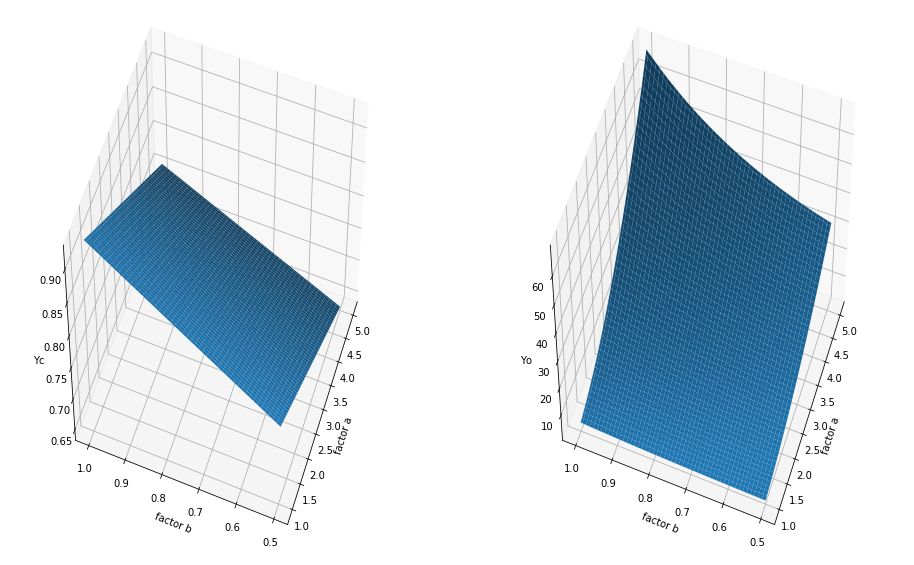

In [16]:
# plt.contourf(x, y, Yo, 50)
# plt.plot_surface(x, y, Yo, 50)

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, Yc)
# ax1.set_zlim([0, 1.2])
ax1.set_xlabel('factor a')
ax1.set_ylabel('factor b')
ax1.set_zlabel('Yc')
ax1.view_init(elev=50., azim=200)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, Yo)
# ax2.set_zlim([0, 100])
# ax2.set_title('Yo')
ax2.set_xlabel('factor a')
ax2.set_ylabel('factor b')
ax2.set_zlabel('Yo')
ax2.view_init(elev=50., azim=200)



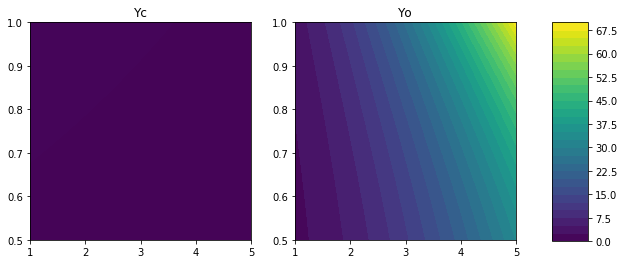

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ca = 30
im = ax[0].contourf(x, y, Yc, ca, vmin=0, vmax=70)
im = ax[1].contourf(x, y, Yo, ca, vmin=0, vmax=70)
ax[0].set_title('Yc')
ax[1].set_title('Yo')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.12, 0.05, 0.76])

fig.colorbar(im, cax=cbar_ax)


# Docs
- [pyDOE: Design of experiments for Python](https://github.com/tisimst/pyDOE)